# Assignment 1

Hello dear students. You have successfully cloned the repo, great.
 - Exercise 0: Warm up tasks.
 - Exercise 1: Color spaces and morphological operators (Lecture 1)
 - Exercise 2: Convolution and Canny Edge detection (Lecture 2)

## Exercise 0 - Image-I/O

There are several python libraries for reading and displaying images. I recommend scikit-image. Execute the next cell and install missing libraries like scikit-image. 

In [1]:
# imports
%matplotlib inline
from skimage import io, data, color
from skimage import img_as_uint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
from numpy import ma
from PIL import Image
import os
import glob
# SET WORKING_DIRECTORY AS REPOSITORY ROOT
os.chdir("..")

In [2]:
def imshow(img, is_gray=False, ax=None, vmax=255):
    if not ax:
        fig, ax = plt.subplots(1)
    cmap = None
    if is_gray:
        cmap = plt.cm.gray
        vmax = 1
    ax.imshow(img,cmap=cmap, vmin=0, vmax=vmax)
    ax.axis("off")

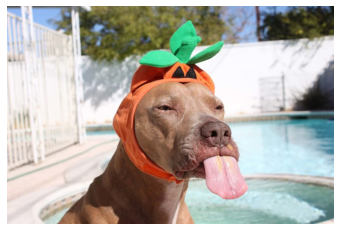

In [3]:
image = io.imread('images/dog.jpg')
imshow(image)

By the way, there are many test images in skimage.data that you can use for your tasks. Execute the next two cells. 

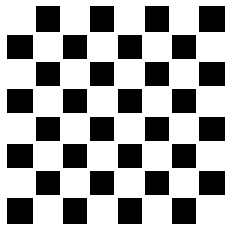

In [4]:
imshow(data.checkerboard(), is_gray=True)

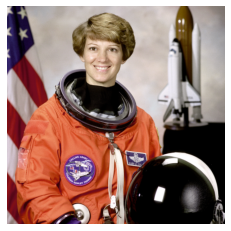

In [5]:
imshow(data.astronaut())

Add a line of code to the next cell to display 440 <= x <= 540 and 250 <= y <= 390 for the dog image!

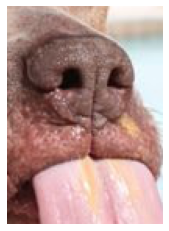

In [6]:
dog_crop = image[250:390,440:540]
imshow(dog_crop)

Now convert the color image to a grayscale image and display it!

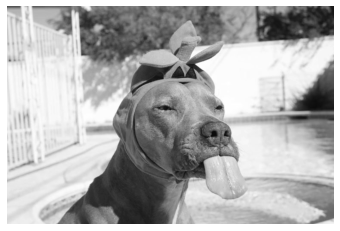

In [7]:
dog_gray = color.rgb2gray(image)
imshow(dog_gray, is_gray=True)

There are other color spaces. For example, HSV will be used in the lecture. Convert your image to HSV and display the H-channel.

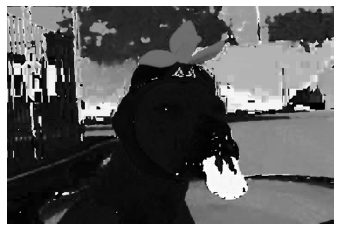

In [8]:
image_hsv = color.rgb2hsv(image)
image_hue = image_hsv[:,:,0]
imshow(image_hue, is_gray=True)

Did you know that HSV now allows creating robust (i.e. lighting independent) color histograms? Create one with Matplotlib!

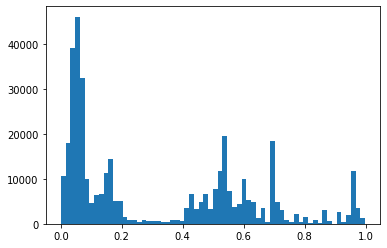

In [9]:
hue_colors = image_hue.flatten()
plt.hist(hue_colors,bins=64)
plt.show()

## Exercise 1 - Color Spaces, Morphological Operators

### Exercise 1.1

For an image of your choice, implement the simple binarization method as shown in the lecture. We've put some example images in `/images` and provided you with one in the next cell.

Rough sketch:

1. define the „positive“ subspace P in the RGB cube
2. iterate over all pixels in I and check if in P or ~P
3. write result to new image
4. play around with size and shape of P and display binary image (**RESULT**)

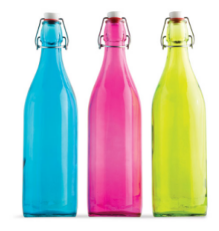

In [10]:
image = io.imread('images/bottles.png')
imshow(image)

In [11]:
def is_pixel_in_subspace(pixel, subspace):
    return (subspace["r"][0] <= pixel[0]) & (pixel[0]<=subspace["r"][1])& (subspace["g"][0] <= pixel[1])& (pixel[1]<=subspace["g"][1])& (subspace["b"][0] <= pixel[2])& (pixel[2]<=subspace["b"][1])

def binarize(img, subspace):
    binary_image = np.zeros(img.shape[:2],dtype=np.uint8)

    for pixel_idx in np.ndindex(img.shape[:2]):
        binary_image[pixel_idx] = is_pixel_in_subspace(img[pixel_idx], subspace)

    return img_as_uint(binary_image) 

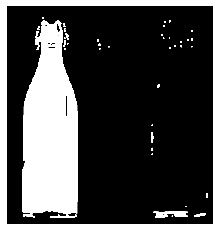

In [12]:
P = {
    "r":(0,140),
    "g":(140,255),
    "b":(0,255)
}

binary_image = binarize(image, P)
imshow(binary_image, is_gray=True)

In [13]:
plt.imsave("./masked_bottle.png", binary_image,cmap=plt.cm.gray)

### Exercise 1.2

* starting from the binary color detection image
* erase noise with an erosion operation
* dilate once to get original size of object
* find connected components with the two-pass algorithm
* extract bounding box on the fly
* draw bounding box on original image (**RESULT**)

In [27]:
KERNEL_PLUS = np.array([[-1,0],[+1,0],[0,-1],[0,+1]])
def erode(img, idx):
    neighbor_idx = KERNEL_PLUS + idx
    neighbors = img[neighbor_idx.T[0], neighbor_idx.T[1] ]
    return int(np.all(neighbors))

def dilate(img, idx):
    neighbor_idx = KERNEL_PLUS + idx
    neighbors = img[neighbor_idx.T[0], neighbor_idx.T[1] ]
    return int(np.any(neighbors))

def erode_img(img):
    img_pad = np.pad(img,pad_width=1,mode='constant', constant_values=(0))
    for pixel_idx in np.ndindex(img.shape):
        pixel_pad_idx = np.array(pixel_idx)+1
        img[pixel_idx] = erode(img_pad, pixel_pad_idx)
    return img    
    
def dilate_img(img):
    img_pad = np.pad(img,pad_width=1,mode='constant', constant_values=(0))
    for pixel_idx in np.ndindex(img.shape):
        pixel_pad_idx = np.array(pixel_idx)+1
        img[pixel_idx] = dilate(img_pad, pixel_pad_idx)
    return img

def remove_noise(img, n_erase=1, n_dilate=1):
    erosion = img.copy()
    for i in range(n_erase):
        erosion = erode_img(erosion)
    dilation = erosion.copy()
    for i in range(n_dilate):
        dilation = dilate_img(dilation)
    return erosion, dilation

def assign_component_id(img, idx, new_id):
    neighbor_idx = KERNEL_PLUS + idx
    neighbors = img[neighbor_idx.T[0], neighbor_idx.T[1] ]
    neighbors_nonzero = neighbors[neighbors != 0]
    if neighbors_nonzero.size == 0:
        pixel_id = new_id
        return pixel_id, new_id + 1
    else:
        pixel_id = np.min(neighbors_nonzero)
        return pixel_id, new_id

def update_bounding_boxes(bboxes, pixel_id, pixel_idx):
    y, x = pixel_idx
    if pixel_id in bboxes:
        bboxes[pixel_id]["x"] = min(bboxes[pixel_id]["x"], x) 
        bboxes[pixel_id]["y"] = min(bboxes[pixel_id]["y"], y) 
        bboxes[pixel_id]["width"] = max(bboxes[pixel_id]["width"], x-bboxes[pixel_id]["x"]+1) 
        bboxes[pixel_id]["height"] = max(bboxes[pixel_id]["height"], y-bboxes[pixel_id]["y"]+1) 
    else:
        bboxes[pixel_id] = {
            "x":x,
            "y":y,
            "width": 1,
            "height": 1
        }
    return bboxes
        

def two_pass_helper(img, components, extract_bboxes=False):
    """Two-pass-algorithm helper method."""
    bboxes = {}
    new_id = np.max(components)+1
    components_pad = np.pad(components,pad_width=1,mode='constant', constant_values=(0))
    for pixel_idx in np.ndindex(img.shape):
        pixel_pad_idx = np.array(pixel_idx)+1
        if img[pixel_idx] > 0:
            pixel_id, new_id = assign_component_id(components_pad, pixel_pad_idx, new_id)
            components_pad[tuple(pixel_pad_idx)] = pixel_id
            bboxes = update_bounding_boxes(bboxes, pixel_id, pixel_idx)
    if extract_bboxes:
        return components_pad[1:-1,1:-1], bboxes
    else:
        return components_pad[1:-1,1:-1]

def two_pass(img):
    """Find connected components with the two-pass-algorithm."""
    components_init = np.zeros_like(img)
    img_reverse = img[::-1,::-1]
    components_prep = two_pass_helper(img_reverse, components_init)
    components_reverse = components_prep[::-1,::-1]
    components, bboxes = two_pass_helper(img,components_reverse,extract_bboxes=True)
    return components, bboxes

def bbox_to_rectangle(bbox):
    return patches.Rectangle((bbox["x"], bbox["y"]), bbox["width"], bbox["height"], linewidth=1, edgecolor='r', facecolor='none')

def show_components(components, bboxes):
    component_ids = np.unique(components)
    print(f"Number of connected components: {component_ids.size}")
    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(8,4))
    max_bbox = None
    max_bbox_area = 0
    for component_id, bbox in bboxes.items():
        axes[0].add_patch(bbox_to_rectangle(bbox))
        bbox_area = bbox["width"]*bbox["height"]
        if max_bbox_area < bbox_area:
            max_bbox = bbox
            max_bbox_area = bbox_area
    imshow(components, is_gray=True, ax=axes[0])
    axes[0].title.set_text("All Components")
    axes[1].add_patch(bbox_to_rectangle(max_bbox))
    imshow(components,is_gray=True, ax=axes[1])
    axes[1].title.set_text("Biggest Component")
    
    
    
def show_noise_removal(original, erosion, dilation):
    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(12,4))
    imshow(original, is_gray=True, ax=axes[0])
    axes[0].title.set_text("Original")
    imshow(erosion, is_gray=True, ax=axes[1])
    axes[1].title.set_text("Erosion")
    imshow(dilation, is_gray=True, ax=axes[2])
    axes[2].title.set_text("Dilation")

class Centers():
    def __init__(self, component_ids, values):
        self.values = np.array(values)
        self.component_ids = np.array(component_ids) 
        
    @classmethod
    def from_bboxes(cls, bboxes):
        values = []
        component_ids = []
        for component_id, bbox in bboxes.items():
            component_ids.append(component_id)
            values.append( [int(bbox["x"]+bbox["width"]/2), int(bbox["y"]+bbox["height"]/2)])
        return cls(component_ids,values)
    
    def get_center_by_id(self, component_id):
        return self.values[np.where(self.component_ids == component_id)][0]
        

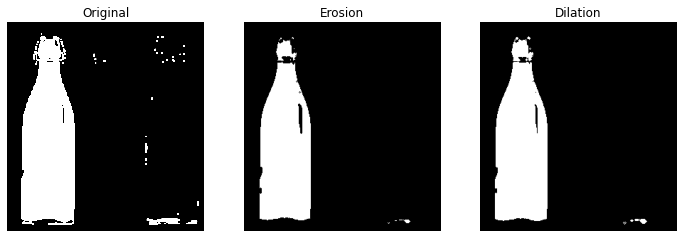

In [15]:
target = binary_image.copy()
erosion, target = remove_noise(target)
show_noise_removal(binary_image, erosion, target)

Number of connected components: 31


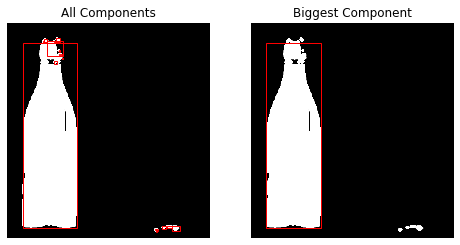

In [16]:
components, bboxes = two_pass(target)
show_components(components, bboxes)

### Exercise 1.3

* use your color detection and connected components algorithm
* implement simplest tracking algorithm
* draw history of all previous points on frame (**RESULT**)

(see images/racecar or images/taco for sample image sequences)

In [17]:


P_taco = {
    "r":(180,255),
    "g":(0,120),
    "b":(0,120)
}


In [79]:
files= sorted(glob.glob("images/taco/*"))
images_original = [io.imread(f) for f in files]

n_figs = 15
fig, axes = plt.subplots(n_figs, figsize=(6,3*n_figs))
for i in range(n_figs):
    imshow(images[100+i],ax=axes[i])

In [19]:
def compute_max_bbox(bboxes):
    max_bbox_id = None
    max_bbox_area = 0
    for component_id, bbox in bboxes.items():
        bbox_area = bbox["width"]*bbox["height"]
        if max_bbox_area < bbox_area:
            max_bbox_id = component_id 
            max_bbox_area = bbox_area
    return max_bbox_id

### Preprocessing of taco images

1. Binarization
2. Noise removal

```python
BINARY_TACO_ROOT = "images/binary_taco/"

if not os.path.exists(BINARY_TACO_ROOT):
    os.makedirs(BINARY_TACO_ROOT)

for i, taco in enumerate(images_original):
    binary_taco = binarize(taco, P_taco)
    _, binary_noiseless_taco = remove_noise(binary_taco,n_erase=2,n_dilate=5)
    plt.imsave(os.path.join(BINARY_TACO_ROOT,os.path.basename( files[i]) ),binary_noiseless_taco,cmap=plt.cm.gray)
```

In [81]:
files= sorted(glob.glob("images/binary_taco/*"))
images = [io.imread(f,as_gray=True) for f in files]

In [82]:
img_init_taco = images[0]

components, bboxes = two_pass(img_init_taco)
#show_components(components, bboxes)

max_bbox_id = compute_max_bbox(bboxes)
centers =Centers.from_bboxes(bboxes)
max_center = centers.get_center_by_id(max_bbox_id)
init_taco_position = max_center

In [83]:
def get_closest_candidate(candidates, position):
    idx = (np.linalg.norm(candidates - position,axis=1)).argmin()
    return candidates[idx]

In [84]:
current_position = init_taco_position
positions = [init_taco_position]
for img in images[1:]:
    components, bboxes = two_pass(img)
    #show_components(components, bboxes)
    max_bbox_id = compute_max_bbox(bboxes)
    candidates = Centers.from_bboxes(bboxes)
    current_position = get_closest_candidate(candidates.values,current_position)
    positions.append(current_position)
positions=np.array(positions)

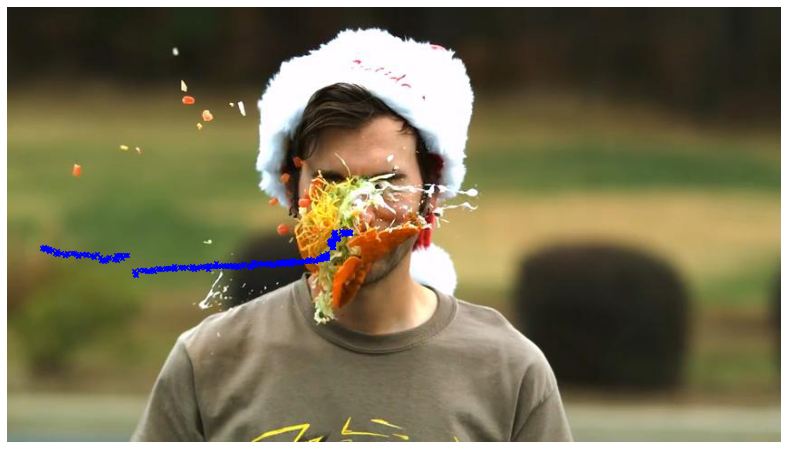

In [85]:
TRACKING_TACO_ROOT = "solutions/taco_tracking/"

if not os.path.exists(TRACKING_TACO_ROOT):
    os.makedirs(TRACKING_TACO_ROOT)

plt.figure(figsize=(16,8))
for i in range(len(positions)):
    plt.imshow(images_original[i])
    plt.scatter(positions[i,0], positions[i,1], marker="x", color="blue",s=20)
    plt.axis("off")
    plt.savefig(os.path.join(TRACKING_TACO_ROOT,f"{i:03d}.png"))

In [86]:
img, *imgs = [Image.open(f) for f in sorted(glob.glob(os.path.join(TRACKING_TACO_ROOT,"*") ))]
img.save(fp="solutions/taco-tracking.gif", format='GIF', append_images=imgs,
         save_all=True, duration=200, loop=0)

### Exercise 1.4 (BONUS)

* find connected components using a one-pass algorithm
* plot the resulting image and compare it to the result of your two-pass implementation (**RESULT**)

## Exercise 2: Convolution and Canny edge detection

### Exercise 2.1: Convolution
Implement the convolution operation for 2-D images (i.e. no colors here, sorry).

In [ ]:
def conv2d(image, kernel):
    # here goes your code
    kernel = np.array(kernel)
    pad_width = int((kernel.shape[0]/2))
    result = np.zeros_like(image)
    image_pad = np.pad(image,pad_width=pad_width,mode='constant', constant_values=(0))
    for col in range(image.shape[1]):
        for row in range(image.shape[0]):
            image_slice = image_pad[row:row+kernel.shape[0],col:col+kernel.shape[1]]
            result[row, col] = np.dot(image_slice.flatten(), kernel.flatten())
    return result

image = color.rgb2gray(io.imread('images/dog.jpg'))

plt.imshow(conv2d(image, [[-1,0,1],[-1,0,1],[-1,0,1]]), cmap='gray')
plt.axis("off")
plt.show()

Convolve an image of your choice with a Gaussian kernel. Play around with the size of the kernel and the standard deviation of the Gaussian. Show your results (***RESULT***).

In [ ]:
def gaussian_kernel(size, std=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g
#conv2d()
gaussian_kernel(3,5)

Now, implement a simple edge detector by first filtering with a Sobel operator and then thresholding the ***RESULT***. How does smoothing the input change the ***RESULT***?

### Exercise 2.2: Canny Edge Detection

#### Preprocessing
If you haven't yet: smooth the image with a Gaussian of your choice. Then use the Sobel operator to create the gradient magnitude and direction matrices (see slides page 23). Round the gradient directions to the 8-neighbor's directions. Display all  intermediate ***RESULT***s!

#### Non-Maximum Suppression
Implement the Non-Maximum Suppression step as described in the lecture. Subtract the result from the gradient magnitude image and show the ***RESULT***!

#### Thresholding and Edge Tracing
Implement the edge tracing as described in the lecture and show the final result for three different threshold pairs: two low thresholds (e.g. 20 and 50), high thresholds (e.g. 80 and 120) and thresholds with large spacing (e.g. 40 and 140). (***RESULT***)

### Congratz, you made it! You can now try to solve this optional exercise.

This exercise is not graded, but might be a good preparation for the exam.

Please go to the following link: https://forms.gle/wMNmbTu1sAAWQz8d8.

In the form, you will find the optional task (and the corresponding consent form in case you agree with us processing your data). The task is formulated in German, and we would prefer German as the language for your answer. However, if you don’t feel comfortable with that, please feel free to solve it in English.


